In [1]:
#pip install tensorflow-datasets


In [2]:
#pip install tensorflow

In [3]:
#pip install scikeras

In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.layers import Dense
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
#import tensorflow_datasets as tdfs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from keras import models
from keras import layers
from keras import regularizers
#from scikeras.wrappers import KerasRegressor
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras import optimizers

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import PIL.Image as Image

#import tensorflow_addons as tfa

In [5]:
#import tensorflow_datasets as tfds
"""cassava_data = tfds.load("cassava")
cassava_train, cassava_test = cassava_data["train"], cassava_data["test"]
assert isinstance(cassava_train, tf.data.Dataset)"""

'cassava_data = tfds.load("cassava")\ncassava_train, cassava_test = cassava_data["train"], cassava_data["test"]\nassert isinstance(cassava_train, tf.data.Dataset)'

In [6]:
"""data_santa_dir = 'data/santa/'
data_not_santa_dir = 'data/not_santa/'
imgs_santa = [file for file in os.listdir(data_santa_dir) if file.endswith('.jpg')]"""

"data_santa_dir = 'data/santa/'\ndata_not_santa_dir = 'data/not_santa/'\nimgs_santa = [file for file in os.listdir(data_santa_dir) if file.endswith('.jpg')]"

In [7]:
train_dir = 'cats_dogs_downsampled/train'
validation_dir = 'cats_dogs_downsampled/val/'
test_dir = 'cats_dogs_downsampled/test/' 

In [8]:
train_data_dir = 'data/train'
test_data_dir = 'data/validation'

In [9]:
print(os.listdir("data"))
#print(os.listdir("../data/train/"))

['cassava-disease.zip', 'extraimages.zip', 'random.txt', 'sample_submission_file.csv', 'test', 'test.zip', 'train', 'train.zip']


In [10]:
os.listdir('./data')

['cassava-disease.zip',
 'extraimages.zip',
 'random.txt',
 'sample_submission_file.csv',
 'test',
 'test.zip',
 'train',
 'train.zip']

In [11]:
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("data/cassava-disease.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

In [12]:
import os
Id = []
for dirname, _, filenames in os.walk('./data/train'):
    for filename in filenames:
        Id.append(os.path.join(dirname, filename))
Id[:5]

['./data/train\\cbb\\train-cbb-0.jpg',
 './data/train\\cbb\\train-cbb-1.jpg',
 './data/train\\cbb\\train-cbb-10.jpg',
 './data/train\\cbb\\train-cbb-100.jpg',
 './data/train\\cbb\\train-cbb-101.jpg']

In [13]:
train=pd.DataFrame()
train=train.assign(filename=Id)
train.head()

,filename
0,./data/train\cbb\train-cbb-0.jpg
1,./data/train\cbb\train-cbb-1.jpg
2,./data/train\cbb\train-cbb-10.jpg
3,./data/train\cbb\train-cbb-100.jpg
4,./data/train\cbb\train-cbb-101.jpg


In [14]:
!unzip /kaggle/input/cassava-disease/extraimages.zip -d  /kaggle/working/ 
!unzip /kaggle/input/cassava-disease/test.zip -d /kaggle/working/
!unzip /kaggle/input/cassava-disease/train.zip -d /kaggle/working/

unzip:  cannot find or open /kaggle/input/cassava-disease/extraimages.zip, /kaggle/input/cassava-disease/extraimages.zip.zip or /kaggle/input/cassava-disease/extraimages.zip.ZIP.
unzip:  cannot find or open /kaggle/input/cassava-disease/test.zip, /kaggle/input/cassava-disease/test.zip.zip or /kaggle/input/cassava-disease/test.zip.ZIP.
unzip:  cannot find or open /kaggle/input/cassava-disease/train.zip, /kaggle/input/cassava-disease/train.zip.zip or /kaggle/input/cassava-disease/train.zip.ZIP.


In [15]:
with ZipFile("data/test.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

In [16]:
with ZipFile("data/train.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

In [17]:
print(os.listdir("./data"))

['cassava-disease.zip', 'extraimages.zip', 'random.txt', 'sample_submission_file.csv', 'test', 'test.zip', 'train', 'train.zip']


In [18]:
print(os.listdir("./data/train"))
print(np.shape(os.listdir("./data/train")))

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
(5,)


In [38]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=3774)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5656)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 3774 images belonging to 1 classes.
Found 5656 images belonging to 5 classes.


In [20]:
train_labels[1]

array([0., 0., 0., 1., 0.], dtype=float32)

In [21]:
test_labels

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [39]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5656, 64, 64, 3)
(5656, 5)
(3774, 64, 64, 3)
(3774, 1)


In [40]:
train_img_unrow = train_images.reshape(5656, -1)
test_img_unrow = test_images.reshape(3774, -1)

# Preview the shape of train_img_unrow
np.shape(train_img_unrow)

(5656, 12288)

In [41]:
X_train = train_images.reshape(5656, 12288).astype('float32')
#X_test = X_test.reshape(3774, 12288).astype('float32')
np.shape(X_train)

(5656, 12288)

In [42]:
train_images /= 255.
test_images /= 255.

## train test split

In [26]:
#train,test= train_test_split( train, test_size=0.2, random_state=42,shuffle=True, stratify=train['label'])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## img class w MLPs

In [44]:
model_1 = models.Sequential()
model_1.add(layers.Dense(256, activation='tanh', input_shape=(12288,)))
model_1.add(layers.Dense(5, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])


In [45]:
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 256)               3145984   
                                                                 
 dense_27 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 3147269 (12.01 MB)
Trainable params: 3147269 (12.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
results_1 = model_1.fit(train_img_unrow, train_labels, epochs=5, batch_size=64) #validation_data=(test_img_unrow, test_labels)


Epoch 1/5
89/89 [==============================] - 5s 33ms/step - loss: 1.4881 - acc: 0.4450
Epoch 2/5
89/89 [==============================] - 4s 48ms/step - loss: 1.3260 - acc: 0.4645
Epoch 3/5
89/89 [==============================] - 3s 36ms/step - loss: 1.3125 - acc: 0.4738
Epoch 4/5
89/89 [==============================] - 3s 34ms/step - loss: 1.3030 - acc: 0.4742
Epoch 5/5
89/89 [==============================] - 3s 33ms/step - loss: 1.2848 - acc: 0.4837


In [47]:
results_train = model_1.evaluate(train_img_unrow, train_labels)

177/177 [==============================] - 2s 10ms/step - loss: 1.2337 - acc: 0.4874


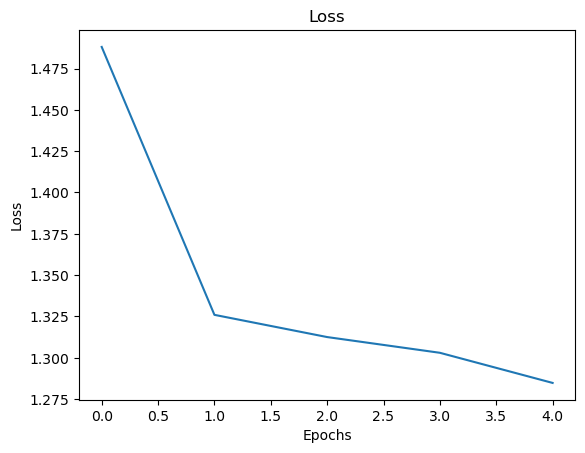

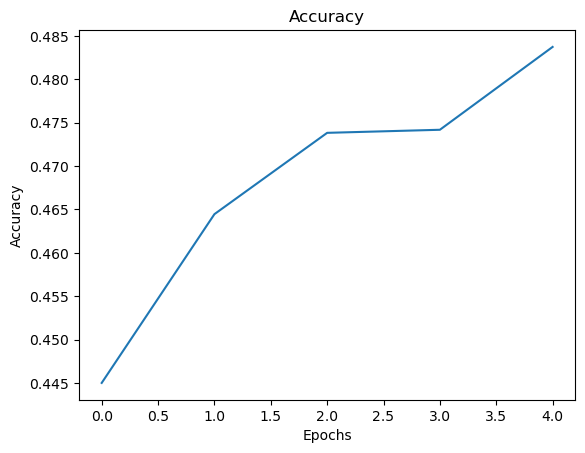

In [48]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    #plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    #plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    #plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    #plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
visualize_training_results(results_1)

## Convolutional codealong- base model

In [50]:
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(12288,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_img_unrow,
                    train_labels,
                    epochs=50,
                    batch_size=32)
                    #validation_data=(val_img, val_y))

Epoch 1/50
177/177 [==============================] - 3s 8ms/step - loss: 0.6743 - accuracy: 0.4634
Epoch 2/50
177/177 [==============================] - 1s 8ms/step - loss: 0.6397 - accuracy: 0.4699
Epoch 3/50
177/177 [==============================] - 1s 7ms/step - loss: 0.6109 - accuracy: 0.4699
Epoch 4/50
177/177 [==============================] - 2s 9ms/step - loss: 0.5865 - accuracy: 0.4699
Epoch 5/50
177/177 [==============================] - 1s 7ms/step - loss: 0.5658 - accuracy: 0.4699
Epoch 6/50
177/177 [==============================] - 1s 7ms/step - loss: 0.5480 - accuracy: 0.4699
Epoch 7/50
177/177 [==============================] - 1s 7ms/step - loss: 0.5328 - accuracy: 0.4699
Epoch 8/50
177/177 [==============================] - 1s 6ms/step - loss: 0.5196 - accuracy: 0.4699
Epoch 9/50
177/177 [==============================] - 1s 8ms/step - loss: 0.5082 - accuracy: 0.4699
Epoch 10/50
177/177 [==============================] - 1s 7ms/step - loss: 0.4982 - accuracy: 0.4699


## CNN

In [51]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(5, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])
cnn_history = cnn_model.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32)#,
                   #validation_data=(val_images, val_y))

Epoch 1/30
177/177 [==============================] - 21s 107ms/step - loss: 0.4695 - acc: 0.4436
Epoch 2/30
177/177 [==============================] - 20s 113ms/step - loss: 0.4279 - acc: 0.4703
Epoch 3/30
177/177 [==============================] - 22s 125ms/step - loss: 0.4270 - acc: 0.4710
Epoch 4/30
177/177 [==============================] - 23s 130ms/step - loss: 0.4257 - acc: 0.4721
Epoch 5/30
177/177 [==============================] - 20s 111ms/step - loss: 0.4246 - acc: 0.4740
Epoch 6/30
177/177 [==============================] - 20s 115ms/step - loss: 0.4230 - acc: 0.4777
Epoch 7/30
177/177 [==============================] - 20s 114ms/step - loss: 0.4217 - acc: 0.4834
Epoch 8/30
177/177 [==============================] - 21s 119ms/step - loss: 0.4194 - acc: 0.4885
Epoch 9/30
177/177 [==============================] - 21s 119ms/step - loss: 0.4174 - acc: 0.4913
Epoch 10/30
177/177 [==============================] - 19s 105ms/step - loss: 0.4145 - acc: 0.5018
Epoch 11/30
177/177

In [52]:
results_train = cnn_model.evaluate(train_images, train_labels)

177/177 [==============================] - 6s 30ms/step - loss: 0.3725 - acc: 0.5852


## CNN from scratch

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

## Tuning models- pipeline stuff- keras wrapper?

In [ ]:
def create_baseline_model():
    
    # Initialize model
    model = models.Sequential()

    # First hidden layer
    model.add(layers.Dense(10, activation='relu', input_shape=(n_features,)))

    # Second hidden layer
    model.add(layers.Dense(5, activation='relu'))

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='SGD', 
                  loss='mse',  
                  metrics=['mse']) 
    
    # Return the compiled model
    return model

In [ ]:
"""keras_wrapper_1 = KerasRegressor(create_baseline_model,  
                                 epochs=150, 
                                 batch_size=256, 
                                 verbose=0)"""

### intermediate activation functions

### display img

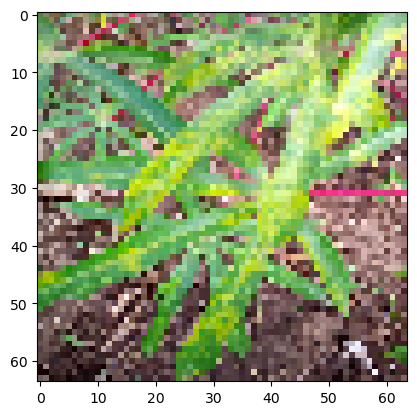

In [53]:
plt.imshow(train_images[0])
plt.show()




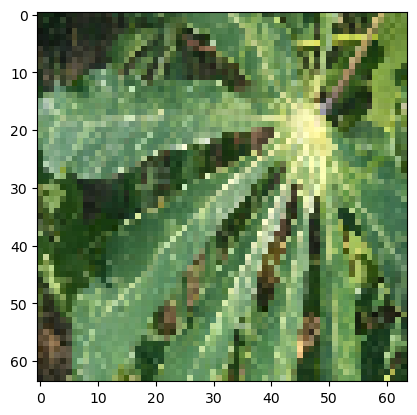

In [54]:

plt.imshow(test_images[0])
plt.show()


## visualize layers

In [59]:
layer_outputs = [layer.output for layer in model_1.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model_1.input, outputs=layer_outputs)

model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 256)               3145984   
                                                                 
 dense_27 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 3147269 (12.01 MB)
Trainable params: 3147269 (12.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
# Returns an array for each activation layer
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

NameError: name 'activation_model' is not defined

## channel 30

In [ ]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

## channel i

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### channel 29 for every layer

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

### viz act lab - plot feature maps

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std() 
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

## Early stopping tuning-neural-networks-with-regularization-lab

In [ ]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
#train
model_2_val = model_2.fit(X_train_tokens, 
                          y_train_lb, 
                          epochs=150, 
                          callbacks=early_stopping, 
                          batch_size=256, 
                          validation_data=(X_val_tokens, y_val_lb))
# eval
results_train = saved_model.evaluate(X_train_tokens, y_train_lb)


## L2 reg.

In [ ]:
# Import regularizers
from keras import regularizers
random.seed(123)
L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,)))

# Add another hidden layer
L2_model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(7, activation='softmax'))

# Compile the model
L2_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L2_model_val = L2_model.fit(X_train_tokens, 
                            y_train_lb, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(X_val_tokens, y_val_lb))

## L1 reg

In [ ]:
random.seed(123)
L1_model = models.Sequential()

# Add the input and first hidden layer
L1_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,)))

# Add a hidden layer
L1_model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
L1_model.add(layers.Dense(7, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L1_model_val = L1_model.fit(X_train_tokens, 
                            y_train_lb, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(X_val_tokens, y_val_lb))

## dropout reg

In [ ]:
dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(2000,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(50, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(25, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(7, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='SGD', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
dropout_model_val = dropout_model.fit(X_train_tokens, 
                                      y_train_lb, 
                                      epochs=150, 
                                      batch_size=256, 
                                      validation_data=(X_val_tokens, y_val_lb))

## normalization tuning-neural-networks-with-normalization-lab